In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
import kagglehub

path = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset")

print("Path to dataset files:", path)

100%|██████████| 13.1M/13.1M [00:00<00:00, 145MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dhruvildave/english-handwritten-characters-dataset/versions/3


In [23]:
import cv2
import os

data_dir = '/root/.cache/kagglehub/datasets/dhruvildave/english-handwritten-characters-dataset/versions/3'

X, y = [], []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".png"):
            path = os.path.join(root, file)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))  # resize for uniformity
            X.append(img.flatten())  # flatten to vector

            #  Extract label from filename (before "_")
            label = file.split("-")[0]
            label = label.replace('img', '')  # '001'
            y.append(label)

X = np.array(X) / 255.0  # normalize
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Available classes:", le.classes_)  #  sanity check

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded
)


Available classes: ['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020' '021' '022' '023' '024'
 '025' '026' '027' '028' '029' '030' '031' '032' '033' '034' '035' '036'
 '037' '038' '039' '040' '041' '042' '043' '044' '045' '046' '047' '048'
 '049' '050' '051' '052' '053' '054' '055' '056' '057' '058' '059' '060'
 '061' '062']


In [24]:
# Show all available classes from dataset
print("Available classes:", le.classes_)

# Pick the first available class (whatever exists)
chosen_class = le.classes_[0]
chosen_class_index = 0

print(f"Chosen class for binary classification: '{chosen_class}'")

# Build binary labels: 1 = chosen class, 0 = rest
y_train_binary = np.where(y_train == chosen_class_index, 1, 0)
y_test_binary = np.where(y_test == chosen_class_index, 1, 0)

print("Train class distribution:", np.bincount(y_train_binary))
print("Test class distribution:", np.bincount(y_test_binary))

Available classes: ['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020' '021' '022' '023' '024'
 '025' '026' '027' '028' '029' '030' '031' '032' '033' '034' '035' '036'
 '037' '038' '039' '040' '041' '042' '043' '044' '045' '046' '047' '048'
 '049' '050' '051' '052' '053' '054' '055' '056' '057' '058' '059' '060'
 '061' '062']
Chosen class for binary classification: '001'
Train class distribution: [2684   44]
Test class distribution: [671  11]


In [25]:

# Initialize weights and bias
weights = np.zeros(X_train.shape[1])
bias = 0
learning_rate = 0.01
epochs = 5

# Step activation function
def step(z):
    return np.where(z >= 0, 1, 0)

# Training loop
for epoch in range(epochs):
    for xi, target in zip(X_train, y_train_binary):
        z = np.dot(xi, weights) + bias
        y_pred = step(z)
        update = learning_rate * (target - y_pred)
        weights += update * xi
        bias += update

# Prediction function
def predict(X):
    z = np.dot(X, weights) + bias
    return step(z)

# Evaluate PLA
y_pred_pla = predict(X_test)



In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# PLA metrics
print("PLA Metrics:")
print("Accuracy:", accuracy_score(y_test_binary, y_pred_pla))
print("Precision:", precision_score(y_test_binary, y_pred_pla, average='macro'))
print("Recall:", recall_score(y_test_binary, y_pred_pla, average='macro'))
print("F1-Score:", f1_score(y_test_binary, y_pred_pla, average='macro'))

PLA Metrics:
Accuracy: 0.9838709677419355
Precision: 0.49193548387096775
Recall: 0.5
F1-Score: 0.4959349593495935


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

num_classes = len(np.unique(y_encoded))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

mlp = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train_cat, validation_split=0.2, epochs=30, batch_size=64)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.0305 - loss: 4.6746 - val_accuracy: 0.0238 - val_loss: 5.1889
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2054 - loss: 3.2154 - val_accuracy: 0.0275 - val_loss: 6.1098
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2839 - loss: 2.7566 - val_accuracy: 0.0165 - val_loss: 7.2097
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3823 - loss: 2.3099 - val_accuracy: 0.0256 - val_loss: 6.3330
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4370 - loss: 2.1140 - val_accuracy: 0.0385 - val_loss: 5.8352
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5147 - loss: 1.7989 - val_accuracy: 0.0348 - val_loss: 6.8231
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5057 - loss: 1.7699 - val_accuracy: 0.0604 - val_loss: 5.2592
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5525 - loss: 1.5793 - val_accuracy: 0.1007 - v

In [39]:
# Accuracy
test_loss, test_acc = mlp.evaluate(X_test, y_test_cat)
print("MLP Test Accuracy:", test_acc)

# Classification report
y_pred_mlp = np.argmax(mlp.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_mlp))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2308 - loss: 6.2051
MLP Test Accuracy: 0.21407625079154968
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        11
           2       1.00      0.18      0.31        11
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11
           5       0.14      0.09      0.11        11
           6       0.11      0.18      0.14        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.40      0.36      0.38        11
          10       0.75      0.27      0.40        11
          11       0.27      0.36      0.31        11
          12       0.53      0.73      0.62        11
          13       0.50      0.09      0.15        11
          14       0.40      0.73     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:

# MLP metrics
print("\nMLP Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Precision:", precision_score(y_test, y_pred_mlp, average='macro'))
print("Recall:", recall_score(y_test, y_pred_mlp, average='macro'))
print("F1-Score:", f1_score(y_test, y_pred_mlp, average='macro'))



MLP Metrics:
Accuracy: 0.21407624633431085
Precision: 0.2461946192502262
Recall: 0.21407624633431085
F1-Score: 0.17819872610237225


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


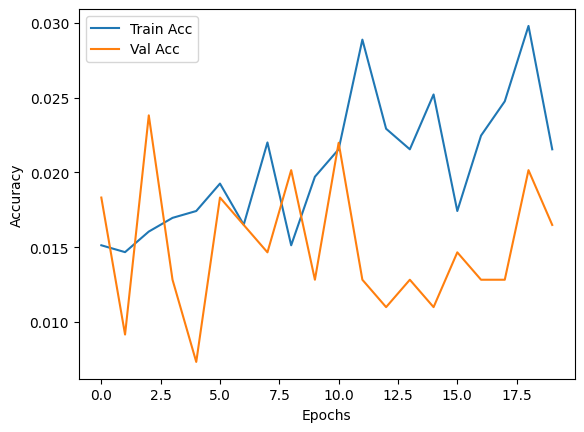

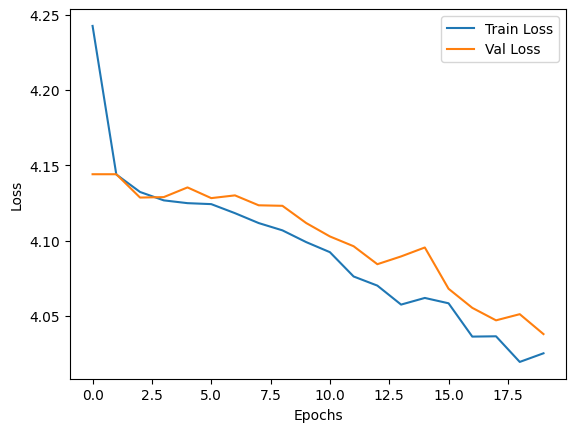

In [41]:
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


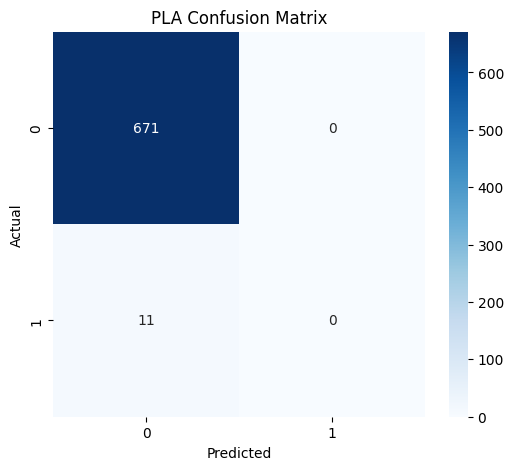

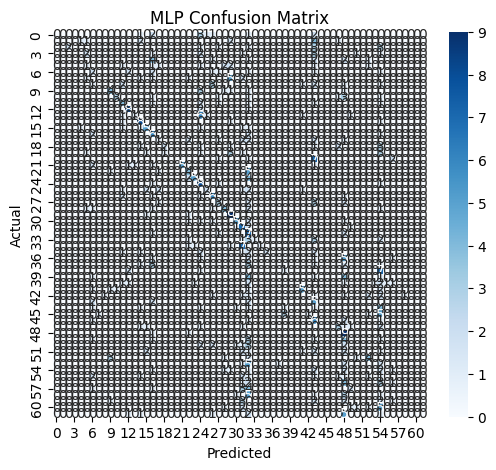

In [47]:
# Function to plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot for PLA
plot_conf_matrix(y_test_binary, y_pred_pla, "PLA Confusion Matrix")

# Plot for MLP
plot_conf_matrix(y_test, y_pred_mlp, "MLP Confusion Matrix")


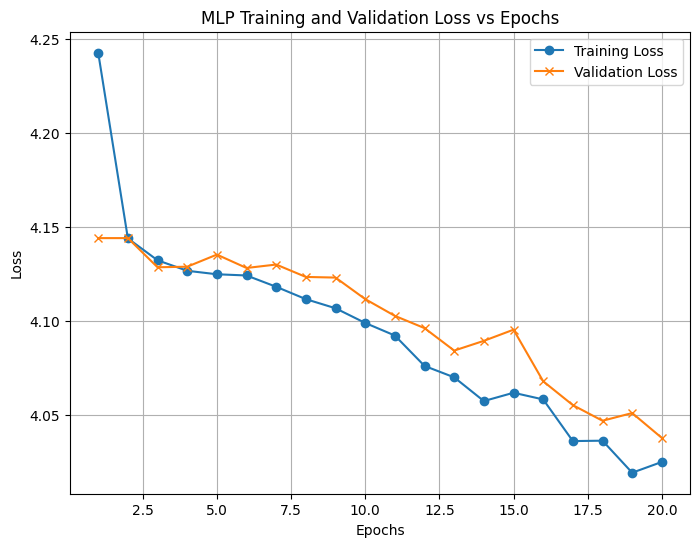

In [48]:
# Extract training loss from history
mlp_loss_epochs = history.history['loss']  # training loss per epoch
val_loss_epochs = history.history['val_loss']  # optional: validation loss per epoch

plt.figure(figsize=(8,6))
plt.plot(range(1, len(mlp_loss_epochs)+1), mlp_loss_epochs, marker='o', label='Training Loss')
plt.plot(range(1, len(val_loss_epochs)+1), val_loss_epochs, marker='x', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


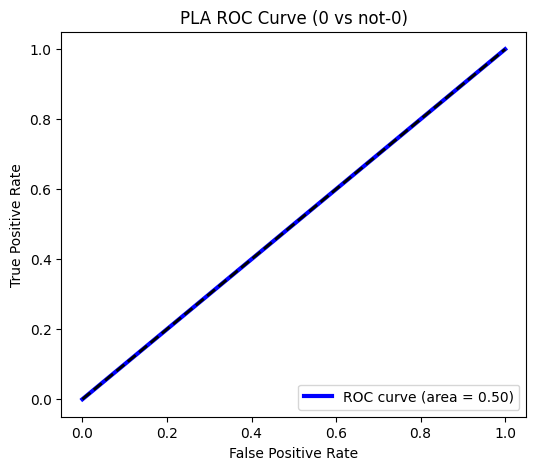

In [49]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_binary, y_pred_pla)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=3, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PLA ROC Curve (0 vs not-0)')
plt.legend(loc='lower right')
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


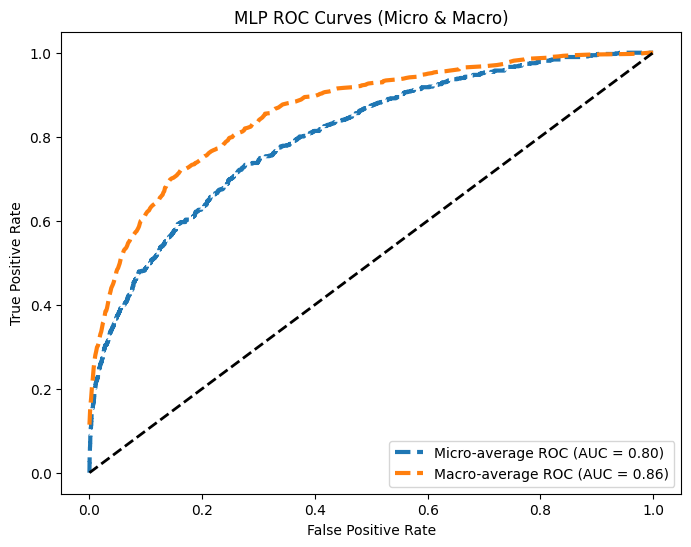

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize test labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
y_score_mlp = mlp.predict(X_test)

# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score_mlp.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_score_mlp[:, i])[0] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_mlp[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= len(classes)
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_micro, tpr_micro, linestyle='--', lw=3, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})')
plt.plot(all_fpr, mean_tpr, linestyle='--', lw=3, label=f'Macro-average ROC (AUC = {roc_auc_macro:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curves (Micro & Macro)')
plt.legend(loc='lower right')
plt.show()


# Experiment 5: Perceptron vs Multilayer Perceptron (A/B Experiment)

## Objective
To implement and compare:
- **Model A**: Single-Layer Perceptron Learning Algorithm (PLA).  
- **Model B**: Multilayer Perceptron (MLP) with hidden layers and nonlinear activations.  

We aim to understand the strengths and weaknesses of simple linear models vs deep neural networks.

## Dataset
- **English Handwritten Characters Dataset**  
- ~3,410 images across 62 classes (digits `0–9`, uppercase `A–Z`, lowercase `a–z`).  
- Each image is resized to 28×28, flattened, and normalized.

## Methodology
1. **Preprocessing**: Resize, flatten, normalize images, encode labels.
2. **PLA Implementation**:
   - Step activation function.
   - Binary classification (digit "0" vs "not-0").
   - Weight update using perceptron learning rule.
3. **MLP Implementation**:
   - Input → Dense(256, ReLU) → Dropout → Dense(128, ReLU) → Dropout → Output(62, Softmax).
   - Trained with Adam optimizer and categorical cross-entropy.
   - Evaluated on full multi-class dataset.
4. **Evaluation Metrics**:
   - Accuracy, Precision, Recall, F1-score.
   - Confusion Matrices.
   - ROC Curves (PLA binary, MLP micro/macro).
   - Training vs Validation loss/accuracy curves.

## Key Insight
- **PLA**: Works only for linearly separable data; underperforms on complex character recognition.  
- **MLP**: Learns nonlinear decision boundaries, achieves much higher accuracy.  
- Highlights the importance of **hyperparameter tuning** (learning rate, optimizer, hidden layers).  

---
